Import Library

In [1]:
import numpy as np 
import pandas as pd  
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve, 
                             matthews_corrcoef, log_loss)
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import re
from itertools import product
import time
from sklearn.ensemble import VotingClassifier
from tqdm import tqdm
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import precision_score, recall_score, f1_score
import pickle

# Read Data

In [2]:
data = pd.read_csv('../Dataset/phishing_email.csv')

In [3]:
data.head(10)

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
5,hpl nom may 31 2001 see attached file hplno 53...,0
6,9760 tried get fancy address came back forward...,0
7,hpl noms february 15 2000 see attached file hp...,0
8,fw pooling contract template original message ...,0
9,hpl nom march 28 2000 see attached file hplo 3...,0


all data is non null

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [5]:
data.nunique()

text_combined    82078
label                2
dtype: int64

In [6]:
# Dropping Duplicates
data = data.drop_duplicates()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82078 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82078 non-null  object
 1   label          82078 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


# Make New data (Balanced 80.000/80.000)

In [8]:
phising_emails = data[data['label']==1]
non_phising_emails = data[data['label']==0]

In [9]:
print(f"Phishing emails count: {len(phising_emails)}")
print(f"Non-phishing emails count: {len(non_phising_emails)}")

Phishing emails count: 42845
Non-phishing emails count: 39233


In [10]:
sample_size = min(len(phising_emails), len(non_phising_emails))

phishing_emails = phising_emails.sample(n=sample_size, random_state=42)
non_phishing_emails = non_phising_emails.sample(n=sample_size, random_state=42)

### make sample as new dataframe


In [11]:
df_sample = pd.concat([phishing_emails, non_phishing_emails]).reset_index(drop=True)
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
print(df_sample)

                                           text_combined  label
0      domingo pittman domingodscltdcom offer perfect...      1
1      transmission losses presentation miss dave per...      0
2      godaddycom wjysgzgodaddycom dear tony meyer st...      0
3      coupons savings wholesale discounts please tak...      1
4      december conference preliminary announcement f...      0
...                                                  ...    ...
78461  get body deserve visioson hpp za net want fat ...      1
78462  qydlqcwsiacfymissuesapacheorg httpissuesapache...      0
78463  jarkko hietaniemi gblikifi xiao yafeng wrote i...      0
78464  paula wheeler gerarddesriauxcnedcnedfr heissme...      1
78465  1 talk health ge ri ia ne cc li b ft ta boo ur...      1

[78466 rows x 2 columns]


save it

In [13]:
df_sample.to_csv('../Dataset/Clean/all_cleaned_shi.csv', index=False)

In [14]:
df_sample.shape


(78466, 2)

In [15]:
df_sample.head()

,text_combined,label
0,domingo pittman domingodscltdcom offer perfect...,1
1,transmission losses presentation miss dave per...,0
2,godaddycom wjysgzgodaddycom dear tony meyer st...,0
3,coupons savings wholesale discounts please tak...,1
4,december conference preliminary announcement f...,0


# EDA

In [16]:
# EDA

In [17]:
label_counts = df_sample['label'].value_counts()

print(f"Phishing emails (label=1): {label_counts.get(1, 0)}")
print(f"Non-phishing emails (label=0): {label_counts.get(0, 0)}")

Phishing emails (label=1): 39233
Non-phishing emails (label=0): 39233


Text Length

In [18]:
df_sample['text_length'] = df_sample['text_combined'].apply(len)
avg_text_length = df_sample.groupby('label')['text_length'].mean()
for label, length in avg_text_length.items():
    label_name = "Non-Phishing" if label == 0 else "Phishing"
    print(f"Average text length for {label_name} emails: {length:.2f} characters")

Average text length for Non-Phishing emails: 1541.46 characters
Average text length for Phishing emails: 1073.89 characters


### Distribusi

In [19]:
# Word Count Analysis

df_sample['word_count'] = df_sample['text_combined'].apply(lambda x: len(x.split()))
avg_word_count = df_sample.groupby('label')['word_count'].mean()

for label, avg_count in avg_word_count.items():
    label_name = "Non-Phishing" if label == 0 else "Phishing"
    print(f"The average word count for {label_name} emails is {avg_count:.2f} words.")

The average word count for Non-Phishing emails is 203.70 words.
The average word count for Phishing emails is 121.80 words.


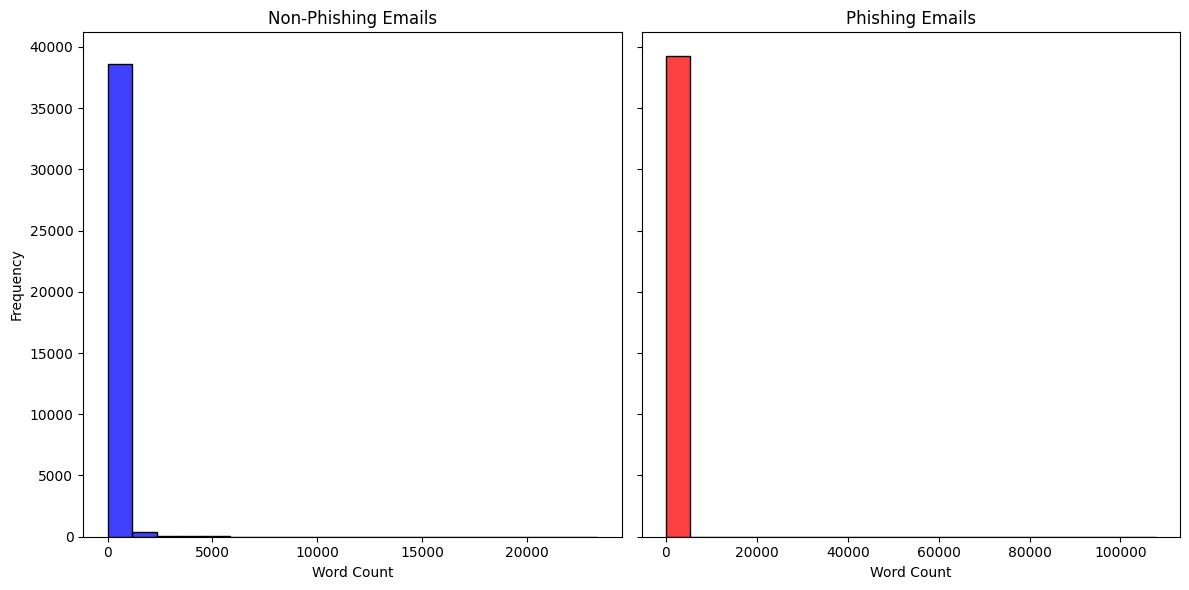

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.histplot(df_sample[df_sample['label'] == 0]['word_count'], bins=20, kde=False, ax=axes[0], color='blue')
axes[0].set_title("Non-Phishing Emails")
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Frequency")

sns.histplot(df_sample[df_sample['label'] == 1]['word_count'], bins=20, kde=False, ax=axes[1], color='red')
axes[1].set_title("Phishing Emails")
axes[1].set_xlabel("Word Count")

plt.tight_layout()
plt.show()

### Word cloud

In [21]:
def preprocess_text(text, unwanted_terms):
    text = text.lower()
    text = re.sub(r'\b\d+\b', '', text) 
    text = re.sub(r'\b(?:mon|tue|wed|thu|fri|sat|sun)\b', '', text, flags=re.IGNORECASE) 
    text = re.sub(r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', '', text, flags=re.IGNORECASE)  
    for term in unwanted_terms:
        text = re.sub(rf'\b{term}\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  

    return text

In [22]:
unwanted_terms = ['enron', 'hpl', 'nom', 'forwarded'] 
df_sample['text_combined'] = df_sample['text_combined'].apply(lambda x: preprocess_text(x, unwanted_terms))

In [23]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

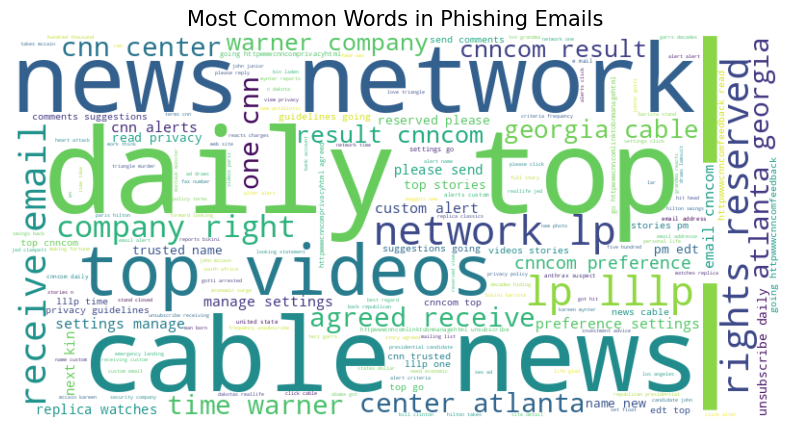

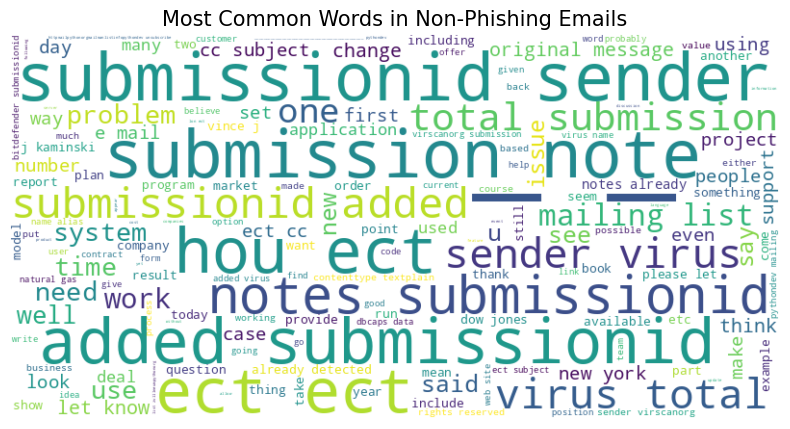

In [24]:
phishing_text = df_sample[df_sample['label'] == 1]['text_combined']
non_phishing_text = df_sample[df_sample['label'] == 0]['text_combined']
plot_wordcloud(phishing_text, "Most Common Words in Phishing Emails")
plot_wordcloud(non_phishing_text, "Most Common Words in Non-Phishing Emails")

In [25]:
def get_top_n_words(text, n=10):
    vectorizer = CountVectorizer(stop_words='english') 
    word_count = vectorizer.fit_transform(text)
    word_freq = dict(zip(vectorizer.get_feature_names_out(), word_count.sum(axis=0).A1))
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    return sorted_words[:n]

In [26]:
# Top 10 Words
phishing_top_words = get_top_n_words(phishing_text, n=10)
non_phishing_top_words = get_top_n_words(non_phishing_text, n=10)

print("Top 10 Words in Phishing Emails:")
for word, freq in phishing_top_words:
    print(f"{word}: {freq}")

print("\nTop 10 Words in Non-Phishing Emails:")
for word, freq in non_phishing_top_words:
    print(f"{word}: {freq}")

Top 10 Words in Phishing Emails:
email: 24095
company: 16526
money: 16255
account: 14947
news: 14592
cnncom: 13280
time: 12954
information: 11877
daily: 11167
cnn: 10720

Top 10 Words in Non-Phishing Emails:
ect: 33923
submissionid: 32246
new: 24685
submission: 21022
added: 20778
sender: 19290
notes: 19272
list: 18459
subject: 17568
virus: 17052


# Model

Splitting data 70/30

In [27]:
X = df_sample['text_combined'] 
y = df_sample['label']         
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

tfidf = TfidfVectorizer(max_features=5000)  
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("Shape of training TF-IDF matrix:", X_train_tfidf.shape)
print("Shape of testing TF-IDF matrix:", X_test_tfidf.shape)

Shape of training TF-IDF matrix: (54926, 5000)
Shape of testing TF-IDF matrix: (23540, 5000)


## Random Forest

In [28]:
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
y_pred_proba_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]

In [29]:
# Random Forest Classification Report
print("\nRandom Forest Classification Report:")
classification_report_rf = classification_report(y_test, y_pred_rf)
print(classification_report_rf)


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     11770
           1       0.98      0.95      0.97     11770

    accuracy                           0.97     23540
   macro avg       0.97      0.97      0.97     23540
weighted avg       0.97      0.97      0.97     23540



In [30]:
# Random Forest Accuracy and Error Rate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
error_rate_rf = 1 - accuracy_rf
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest Error Rate: {error_rate_rf:.2f}")

Random Forest Accuracy: 0.97
Random Forest Error Rate: 0.03


Tuning kecil-kecilan jumlah pohon

In [31]:
estimators = list(range(10, 201, 20)) 
accuracy_scores = []
error_rates = []
for n in estimators:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_model.fit(X_train_tfidf, y_train)
    y_pred_rf = rf_model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred_rf)
    error_rate = 1 - acc
    accuracy_scores.append(acc)
    error_rates.append(error_rate)

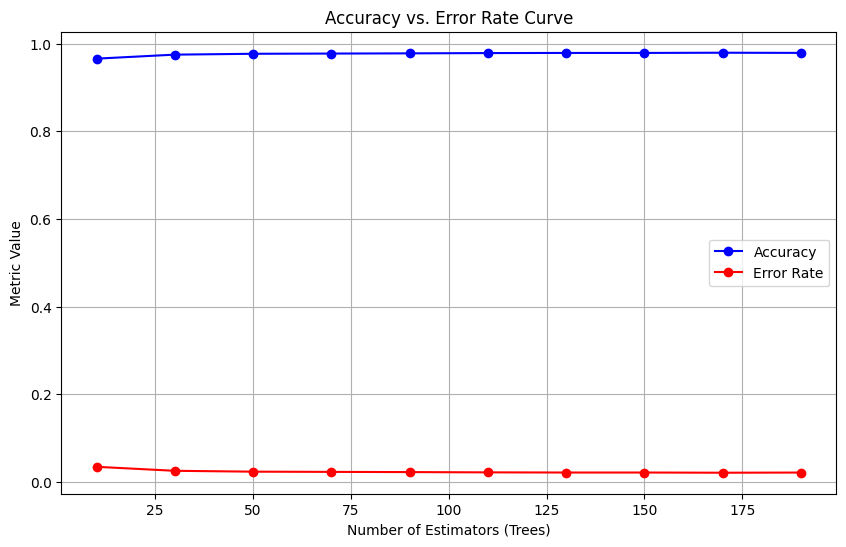

In [32]:
# Accuracy v.s. Error Rate Line Plot
plt.figure(figsize=(10, 6))
plt.plot(estimators, accuracy_scores, label='Accuracy', marker='o', color='blue') # estimators instead of c-values
plt.plot(estimators, error_rates, label='Error Rate', marker='o', color='red')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Metric Value')
plt.title('Accuracy vs. Error Rate Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Hasil pohon / n_estimators kurang lebih hampir sama, paling bagus: 50, 110, 200.

In [33]:
# Random Forest Confusion matrix
print("\nConfusion Matrix:")
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)



Confusion Matrix:
[[11577   193]
 [  305 11465]]


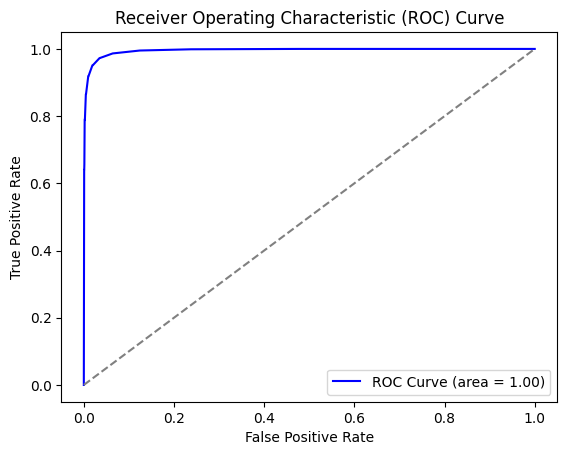

AUC: 1.00


In [34]:
# Random Forest ROC Curve and AUC
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f"AUC: {roc_auc:.2f}")

In [35]:
# Random Forest Log Loss
log_loss_value = log_loss(y_test, y_pred_proba_rf)
print(f"Log Loss: {log_loss_value:.2f}")

Log Loss: 0.13


Hasil Distribusi Prediksi dengan model RF

In [36]:
pred_counts = pd.Series(y_pred_rf).value_counts()
labels = ['Non-Phishing', 'Phishing']
sizes = pred_counts.values
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)

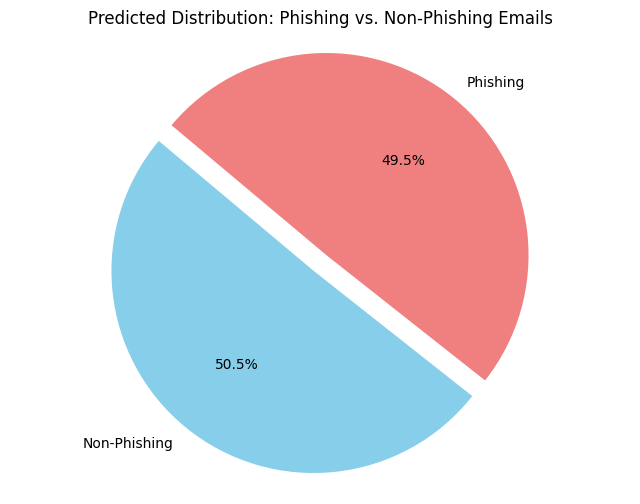

In [37]:
# Pie Chart Phishing v.s. Non-Phishing Distribution
plt.figure(figsize=(8, 6))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors, 
    explode=explode
)
plt.title('Predicted Distribution: Phishing vs. Non-Phishing Emails')
plt.axis('equal')  
plt.show()

## Logistic Regression

In [38]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_tfidf, y_train)
y_pred_logreg = logreg_model.predict(X_test_tfidf)
y_pred_proba_logreg = logreg_model.predict_proba(X_test_tfidf)[:, 1]

In [39]:
# Logistic Regression Classification Report
print("\nLogistic Regression Classification Report:")
classification_report_lr = classification_report(y_test, y_pred_logreg)
print(classification_report_lr)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11770
           1       0.98      0.98      0.98     11770

    accuracy                           0.98     23540
   macro avg       0.98      0.98      0.98     23540
weighted avg       0.98      0.98      0.98     23540



In [40]:
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
error_rate_logreg = 1 - accuracy_logreg
print(f"Logistic Regression Accuracy: {accuracy_logreg:.2f}")
print(f"Logistic Regression Error Rate: {error_rate_logreg:.2f}")

Logistic Regression Accuracy: 0.98
Logistic Regression Error Rate: 0.02


In [41]:
# c-values for log regression
c_values = np.logspace(-3, 3, 10)  # c-values for log regression
accuracy_scores = []
error_rates = []
for c in c_values:
    logreg_model = LogisticRegression(C=c, max_iter=1000, random_state=42)
    logreg_model.fit(X_train_tfidf, y_train)
    y_pred_logreg = logreg_model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred_logreg)
    error_rate = 1 - acc
    accuracy_scores.append(acc)
    error_rates.append(error_rate)

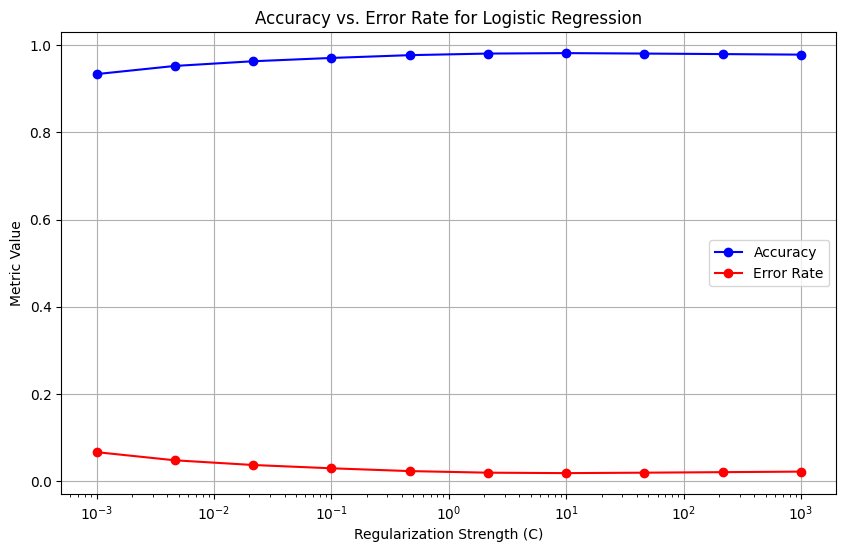

In [42]:
# Accuracy vs. Error Rate
plt.figure(figsize=(10, 6))
plt.plot(c_values, accuracy_scores, label='Accuracy', marker='o', color='blue')
plt.plot(c_values, error_rates, label='Error Rate', marker='o', color='red')
plt.xscale('log')  
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Metric Value')
plt.title('Accuracy vs. Error Rate for Logistic Regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Best C for Logistic Regression: 10, 100, 1000

In [43]:
# Logistic Regression Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix_lr = confusion_matrix(y_test, y_pred_logreg)
print(conf_matrix_lr)


Confusion Matrix:
[[11499   271]
 [  232 11538]]


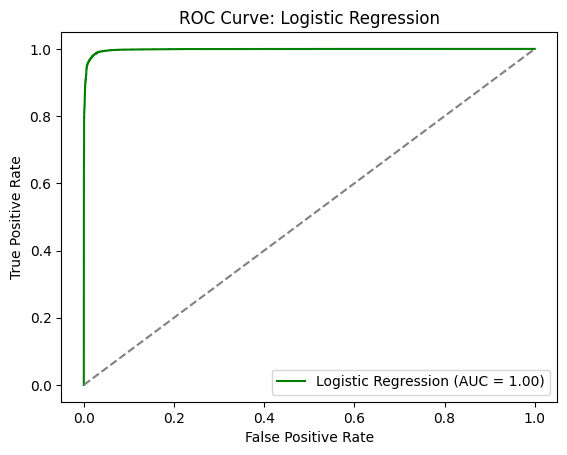

AUC: 1.00


In [44]:
# Logistic Regression ROC Curve and AUC
roc_auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)

plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})', color='green')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression')
plt.legend(loc='lower right')
plt.show()

print(f"AUC: {roc_auc_logreg:.2f}")

In [45]:
# Logistical Regression Log Loss
log_loss_value_logreg = log_loss(y_test, y_pred_proba_logreg)
print(f"Log Loss: {log_loss_value_logreg:.2f}")

Log Loss: 0.08


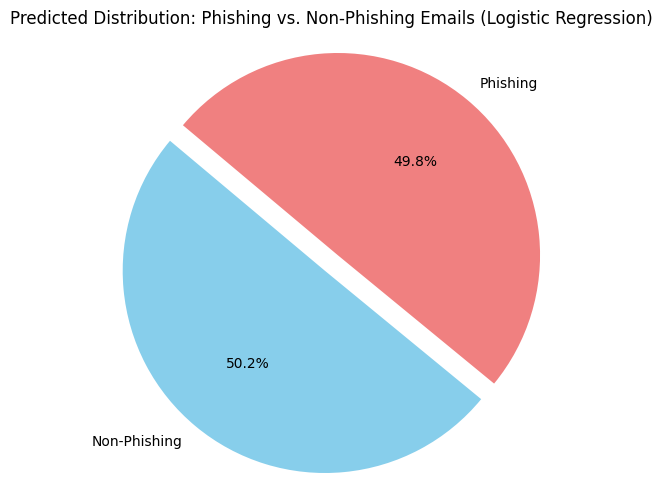

In [46]:
pred_counts_logreg = pd.Series(y_pred_logreg).value_counts()
labels = ['Non-Phishing', 'Phishing']  # Assuming 0 = Non-Phishing, 1 = Phishing
sizes = pred_counts_logreg.values
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors, 
    explode=explode
)
plt.title('Predicted Distribution: Phishing vs. Non-Phishing Emails (Logistic Regression)')
plt.axis('equal')  
plt.show()

In [47]:
with open('../Model/80000_rf_classic.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('../Model/80000_logreg_classic.pkl', 'wb') as f:
    pickle.dump(logreg_model, f)


## SVC (Support Vector Classification)

In [48]:
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
y_pred_proba_svm = svm_model.predict_proba(X_test_tfidf)[:, 1]

In [58]:
# SVC Classification Report
print("\nSVC Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVC Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     11770
           1       0.98      0.99      0.98     11770

    accuracy                           0.98     23540
   macro avg       0.98      0.98      0.98     23540
weighted avg       0.98      0.98      0.98     23540



In [59]:
# SVM Accuracy and Error Rate
accuracy_svm = accuracy_score(y_test, y_pred_svm)
error_rate_svm = 1 - accuracy_svm
print(f"SVM Accuracy: {accuracy_svm:.2f}")
print(f"SVM Error Rate: {error_rate_svm:.2f}")

SVM Accuracy: 0.98
SVM Error Rate: 0.02


Hyperparameter kecil-kecilan


lama bet 600 menit

In [51]:
# # c-values for svm
# c_values = np.logspace(-3, 3, 10) #
# accuracy_scores = []
# error_rates = []
# for c in c_values:
#     svm_model = SVC(kernel='linear', probability=True, C=c, random_state=42)
#     svm_model.fit(X_train_tfidf, y_train)
#     y_pred_svm = svm_model.predict(X_test_tfidf)
#     acc = accuracy_score(y_test, y_pred_svm)
#     error_rate = 1 - acc
#     accuracy_scores.append(acc)
#     error_rates.append(error_rate)

HOW TO Maybe?

directory: manifest.json = what your extension gonna do?, permission?, access to? acces point.
2 addtional files: 
html = what will it look like.
js = describe some different thing that can do.

do = developer mode -> extension directory -> load the folder.

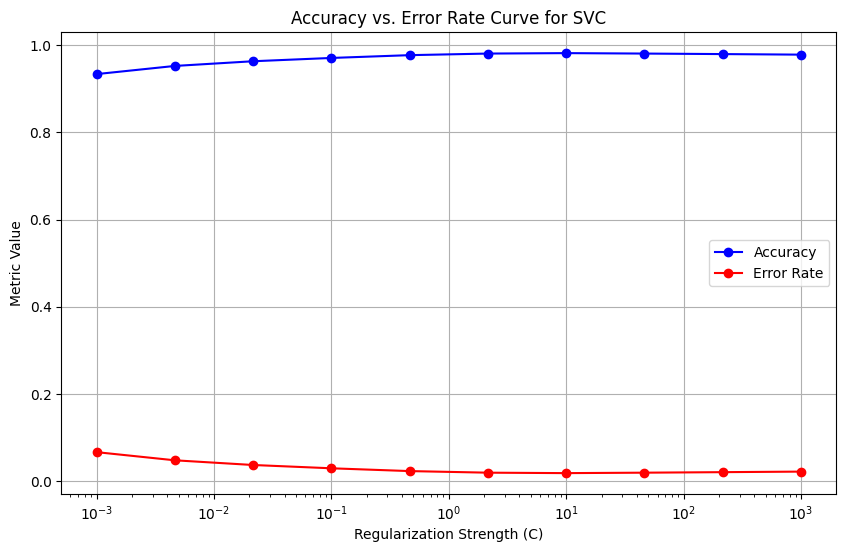

In [52]:
# Accuracy vs. Error Rate Curve
plt.figure(figsize=(10, 6))
plt.plot(c_values, accuracy_scores, label='Accuracy', marker='o', color='blue')
plt.plot(c_values, error_rates, label='Error Rate', marker='o', color='red')
plt.xscale('log')  # Logarithmic scale for C values
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Metric Value')
plt.title('Accuracy vs. Error Rate Curve for SVC')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Best C for SVC: 10

In [60]:
# SVC Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_svm)
print(conf_matrix)


Confusion Matrix:
[[11504   266]
 [  154 11616]]


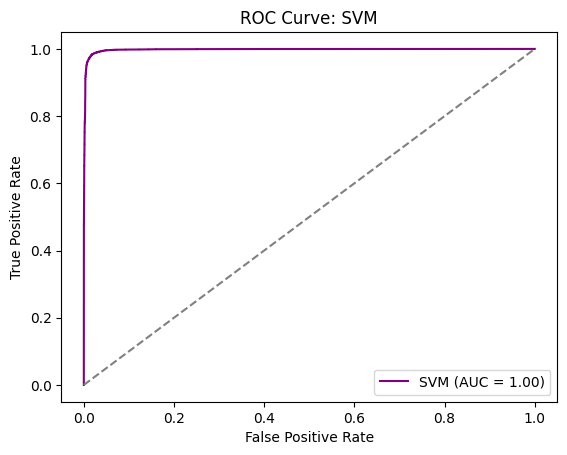

AUC: 1.00


In [61]:
# SVC ROC Curve and AUC
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)

plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})', color='purple')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SVM')
plt.legend(loc='lower right')
plt.show()

print(f"AUC: {roc_auc_svm:.2f}")

Distribusi Hasil prediksi

In [62]:
pred_counts_svm = pd.Series(y_pred_svm).value_counts()
labels = ['Non-Phishing', 'Phishing']  
sizes = pred_counts_svm.values
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)

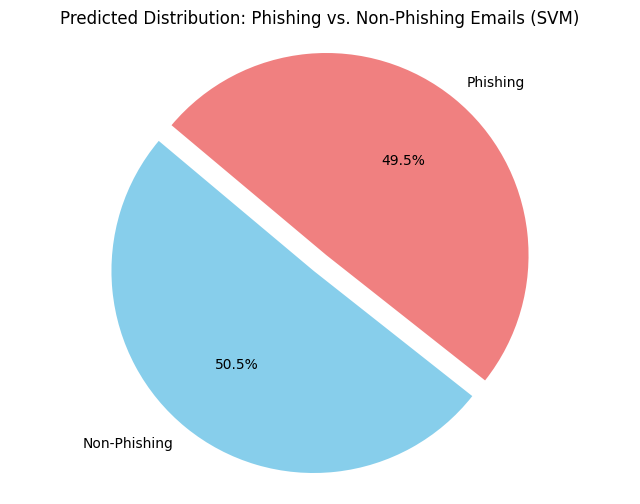

In [63]:
# Pie Chart Phishing v.s. Non-Phishing Distribution
plt.figure(figsize=(8, 6))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors, 
    explode=explode
)
plt.title('Predicted Distribution: Phishing vs. Non-Phishing Emails (SVM)')
plt.axis('equal') 
plt.show()

In [64]:
# SVC Log Loss
log_loss_value_svm = log_loss(y_test, y_pred_proba_svm)
print(f"Log Loss: {log_loss_value_svm:.2f}")

Log Loss: 0.05


## XGBoost

In [65]:
xgb_model = XGBClassifier(
    use_label_encoder=False,  
    eval_metric='logloss', 
    random_state=42
)
xgb_model.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb_model.predict(X_test_tfidf)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_tfidf)[:, 1]

/home/rul/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:32:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [66]:
# Classification Report
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     11770
           1       0.96      0.98      0.97     11770

    accuracy                           0.97     23540
   macro avg       0.97      0.97      0.97     23540
weighted avg       0.97      0.97      0.97     23540



In [68]:
# XGBoost Accuracy and Error Rate
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
error_rate_xgb = 1 - accuracy_xgb
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")
print(f"XGBoost Error Rate: {error_rate_xgb:.2f}")

XGBoost Accuracy: 0.97
XGBoost Error Rate: 0.03


In [69]:
# calc estimators
n_estimators_range = list(range(10, 110, 20))
accuracy_scores = []
error_rates = []
for n in n_estimators_range:
    xgb_model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=n,
        random_state=42
    )
    xgb_model.fit(X_train_tfidf, y_train)
    y_pred_xgb = xgb_model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred_xgb)
    error_rate = 1 - acc
    accuracy_scores.append(acc)
    error_rates.append(error_rate)

/home/rul/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:52:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/rul/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:52:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/rul/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:52:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/rul/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:53:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/rul/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserW

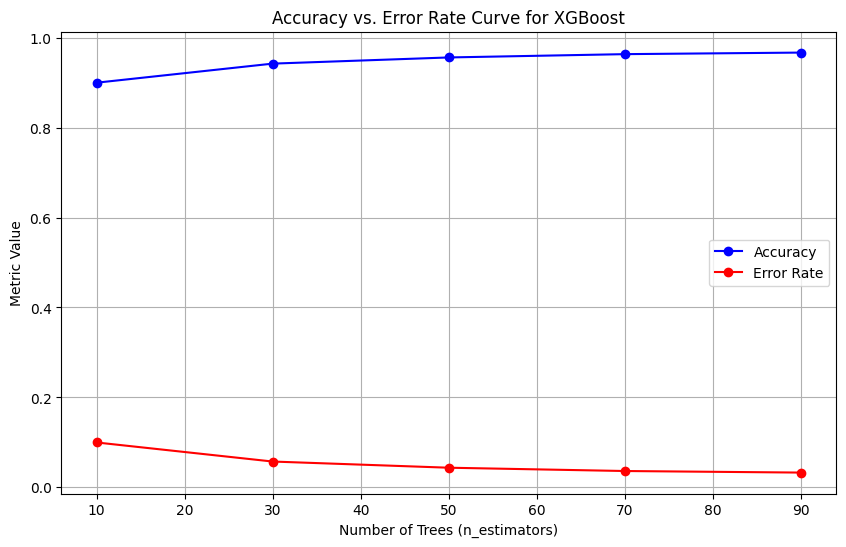

In [70]:
# XGBoost Accuracy vs. Error Rate Curve
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, label='Accuracy', marker='o', color='blue')
plt.plot(n_estimators_range, error_rates, label='Error Rate', marker='o', color='red')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Metric Value')
plt.title('Accuracy vs. Error Rate Curve for XGBoost')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Best Hyperparameter for tree: 30 & 90

In [71]:
# XGBoost Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print(conf_matrix)


Confusion Matrix:
[[11213   557]
 [  204 11566]]


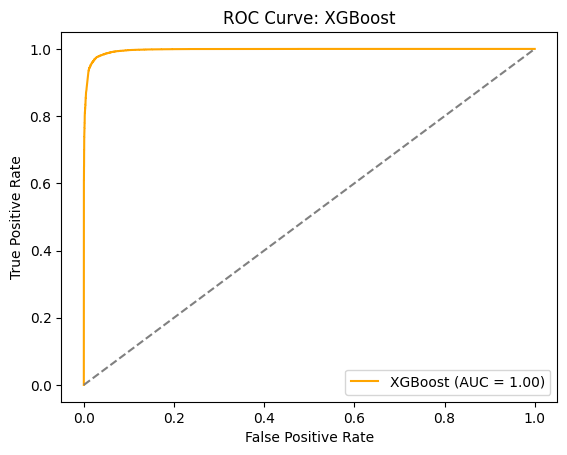

In [72]:
# XGBoost ROC Curve and AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', color='orange')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: XGBoost')
plt.legend(loc='lower right')
plt.show()

In [73]:
# XGBoost Log Loss
log_loss_value_xgb = log_loss(y_test, y_pred_proba_xgb)
print(f"Log Loss: {log_loss_value_xgb:.2f}")

Log Loss: 0.10


Distribusi Hasil Prediksi XGBoost

In [74]:
pred_counts_xgb = pd.Series(y_pred_xgb).value_counts()
labels = ['Non-Phishing', 'Phishing'] 
sizes = pred_counts_xgb.values
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)

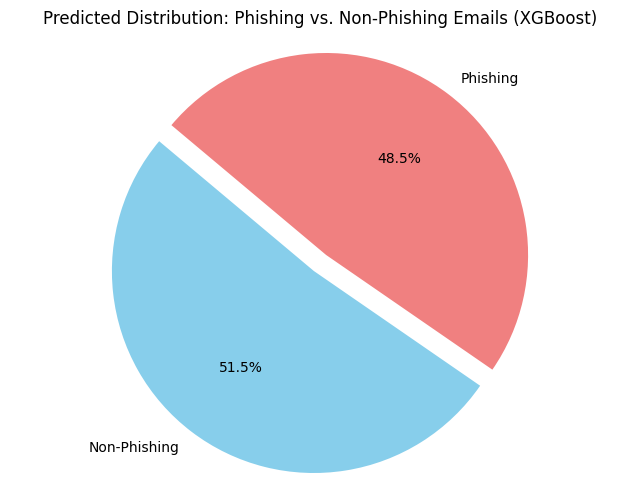

In [75]:
# Pie Chart Phishing v.s. Non-Phishing Distribution
plt.figure(figsize=(8, 6))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors, 
    explode=explode
)
plt.title('Predicted Distribution: Phishing vs. Non-Phishing Emails (XGBoost)')
plt.axis('equal')
plt.show()

## Result all Model

In [291]:
# print("Result from Random Forest")
# print(classification_report_rf)
# print(f"Random Forest Error Rate: {error_rate_rf:.2f}")
# print(f"AUC: {roc_auc:.2f}")
# print(f"Log Loss: {log_loss_value:.2f}")
# print(conf_matrix_rf)

# print()

# print("Result from Logistic Regression")
# print(classification_report_lr)
# print(f"Logistic Regression Error Rate: {error_rate_logreg:.2f}")
# print(f"AUC: {roc_auc_logreg:.2f}")
# print(f"Log Loss: {log_loss_value_logreg:.2f}")
# print(conf_matrix_lr)

# print()

# print("Result from SVC")
# print(classification_report(y_test, y_pred_svm))

## Pickle Early Model

In [76]:
# with open('../Model/rf_classic.pkl', 'wb') as f:
#     pickle.dump(rf_model, f)

# # with open('../Model/logreg_classic.pkl', 'wb') as f:
#     pickle.dump(logreg_model, f)

with open('../Model/80k_xgb_classic.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

with open('../Model/80k_svm_classic.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

# Test Email: 50 emails

- subset 50 emails
- on 4 models
- look misclassified text lenghts
- look missclasified features



In [293]:
# Subset of 50 Emails
X_test_subset = X_test.sample(n=50, random_state=42)
y_test_subset = y_test.loc[X_test_subset.index]

In [294]:
subset_df = pd.DataFrame({
    "Email Text": X_test_subset,
    "True Label": y_test_subset
}).reset_index(drop=True)


print(subset_df.head(10))

                                          Email Text  True Label
0  erc financing regards existing deal setup cost...           0
1  jeannie gustafson jeannieenglewoodbankcom dont...           1
2  clal abdul one time discount order vl gra clal...           1
3  young gould duncanfantasistbray50statescom tha...           1
4  ponderosa pine energy plant start fyi ponderos...           0
5  andrew silver andrewsilvervirgilioit presley w...           1
6  chance prizes regis kelly give away bait excel...           1
7  red rock expansion suggested general format so...           0
8  v g r generic cialis regalis cheap prices plac...           1
9  eastrans nomination change effective please in...           0


In [295]:
subset_indices = np.random.choice(range(X_test_tfidf.shape[0]), size=50, replace=False)
X_test_subset_tfidf = X_test_tfidf[subset_indices]
y_test_subset = y_test.iloc[subset_indices]

## Random Forest 

In [296]:
y_pred_rf_subset = rf_model.predict(X_test_subset_tfidf)
y_pred_proba_rf_subset = rf_model.predict_proba(X_test_subset_tfidf)[:, 1]

In [297]:
accuracy_rf_subset = accuracy_score(y_test_subset, y_pred_rf_subset)
errors_rf_subset = (y_pred_rf_subset != y_test_subset).sum()
mcc_rf_subset = matthews_corrcoef(y_test_subset, y_pred_rf_subset)
log_loss_rf_subset = log_loss(y_test_subset, y_pred_proba_rf_subset)
roc_auc_rf_subset = roc_auc_score(y_test_subset, y_pred_proba_rf_subset)
conf_matrix_rf_subset = confusion_matrix(y_test_subset, y_pred_rf_subset)

In [298]:
print("Random Forest on Subset Evaluation:")
print(f"  Accuracy: {accuracy_rf_subset:.2f}")
print(f"  Errors: {errors_rf_subset}")
print(f"  MCC: {mcc_rf_subset:.2f}")
print(f"  Log Loss: {log_loss_rf_subset:.2f}")
print(f"  AUC: {roc_auc_rf_subset:.2f}")
print(f"  Confusion Matrix:\n{conf_matrix_rf_subset}")

Random Forest on Subset Evaluation:
  Accuracy: 0.86
  Errors: 7
  MCC: 0.72
  Log Loss: 0.36
  AUC: 0.96
  Confusion Matrix:
[[25  5]
 [ 2 18]]


Misclasified Emails

In [299]:
X_test_subset_reset = X_test_subset.reset_index(drop=True)
y_test_subset_reset = y_test_subset.reset_index(drop=True)
y_pred_rf_subset_reset = pd.Series(y_pred_rf_subset).reset_index(drop=True)


In [300]:
misclassified_rf_subset = pd.DataFrame({
    "Email Text": X_test_subset_reset,
    "True Label": y_test_subset_reset,
    "Predicted Label": y_pred_rf_subset_reset
})

In [301]:
misclassified_rf_subset = misclassified_rf_subset[misclassified_rf_subset["True Label"] != misclassified_rf_subset["Predicted Label"]]
print("\nMisclassified Emails (Random Forest):")
misclassified_rf_subset


Misclassified Emails (Random Forest):


,Email Text,True Label,Predicted Label
2,clal abdul one time discount order vl gra clal...,0,1
9,eastrans nomination change effective please in...,1,0
11,james desouza jdsouza1hotvoicecom fromjames de...,0,1
13,doreen metcalf desireephysiotherapypollockuwin...,1,0
30,efren jarvis aldenhypochlorousvalenzuelalostpe...,0,1
33,weather crude list proposed netco employees am...,0,1
39,qs phonemicity writing stimulated richard spro...,0,1


Notes for Analysis:
--
-
-
-

In [302]:
misclassified_rf_subset['Text Length'] = misclassified_rf_subset['Email Text'].apply(len)
print(misclassified_rf_subset[['Text Length', 'True Label', 'Predicted Label']])

    Text Length  True Label  Predicted Label
2           298           0                1
9           147           1                0
11         1125           0                1
13          239           1                0
30          340           0                1
33          955           0                1
39          998           0                1


In [303]:
# i'm grabbing the longest and shortest lengths to further inspect the emails
longest_email = misclassified_rf_subset.loc[misclassified_rf_subset['Text Length'].idxmax()]
shortest_email = misclassified_rf_subset.loc[misclassified_rf_subset['Text Length'].idxmin()]

In [304]:
# Longest 
print("Longest Email:")
print(f"Text Length: {longest_email['Text Length']}")
print(f"True Label: {longest_email['True Label']}")
print(f"Predicted Label: {longest_email['Predicted Label']}")
print(f"Email Text:\n{longest_email['Email Text']}")

Longest Email:
Text Length: 1125
True Label: 0
Predicted Label: 1
Email Text:
james desouza jdsouza1hotvoicecom fromjames desouzaregional director national trust security company sarl lometogo tel00228 attndear friend wish proposal come surprise james desouza regional director national trust security company sarl regional office lometogo foreign client mohamed mohd salaheldinwho deposited huge sum amount us45millionfour million five hundred thousand united states dollars company unfortunatelythis client among victims egyptair flight no990 crashed usa confirmable websitewwwcnncomus991102egyptair990listindexhtml since body come claims next kin sitaution monitored closely position company monitored deposit managed years death hence nobody showed next kin past two years plus removed file private vault solicit assistance present next kin every arrangement concluded waiting foreigner enable move funds account risk attached internal documentations would handled b every loop holes sealed there

In [305]:
# Shortest
print("Shortest Email:")
print(f"Text Length: {shortest_email['Text Length']}")
print(f"True Label: {shortest_email['True Label']}")
print(f"Predicted Label: {shortest_email['Predicted Label']}")
print(f"Email Text:\n{shortest_email['Email Text']}")

Shortest Email:
Text Length: 147
True Label: 1
Predicted Label: 0
Email Text:
eastrans nomination change effective please increase deliveries eastrans mmbtu dy effective continue notified redeliveries fuels cotton valley pg e


Text Length Analysis:
-
-
-

BENTARAN DILANJUTIN!!!

# Ensembled Model


In [306]:
#RF Optimal Parameters
rf_model = RandomForestClassifier(
    max_features=5000,
    n_estimators=50,
    max_depth=None,
    random_state=42
)

In [307]:
#LR Optimal Parameters
lr_model = LogisticRegression(
    C=10.0,
    solver='liblinear',
    penalty='l2',
    random_state=42
)

In [308]:
# SVM Optimal Parameters
svm_model = SVC(
    C=10.0,
    kernel='sigmoid',
    gamma='scale',
    probability=True,
    random_state=42
)

In [309]:
# XGB Optimal Parameters
xgb_model = XGBClassifier(
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    colsample_bytree=0.7,
    random_state=42
)

In [310]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('Random Forest', rf_model),
        ('Logistic Regression', lr_model),
        ('SVM', svm_model),
        ('XGBoost', xgb_model)
    ],
    voting='soft'  
)

In [311]:
# Size of 500
print("Size of Training Data (TF-IDF):", X_train_tfidf.shape)
print("Size of Testing Data (TF-IDF):", X_test_tfidf.shape)

Size of Training Data (TF-IDF): (350, 5000)
Size of Testing Data (TF-IDF): (150, 5000)


In [312]:
voting_clf.fit(X_train_tfidf, y_train)
y_pred_voting = voting_clf.predict(X_test_tfidf)
y_pred_proba_voting = voting_clf.predict_proba(X_test_tfidf)[:, 1]

In [313]:
accuracy_voting = accuracy_score(y_test, y_pred_voting)
auc_voting = roc_auc_score(y_test, y_pred_proba_voting)
logloss_voting = log_loss(y_test, y_pred_proba_voting)
mcc_voting = matthews_corrcoef(y_test, y_pred_voting)

In [314]:
report_voting = classification_report(y_test, y_pred_voting)

print("Metrics for Voting Classifier:")
print(f"Accuracy: {accuracy_voting:.4f}")
print(f"AUC: {auc_voting:.4f}")
print(f"Log Loss: {logloss_voting:.4f}")
print(f"MCC: {mcc_voting:.4f}\n")
print("Classification Report:")
print(report_voting)

Metrics for Voting Classifier:
Accuracy: 0.9333
AUC: 0.9799
Log Loss: 0.2584
MCC: 0.8670

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        75
           1       0.95      0.92      0.93        75

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



## Voting Clasifier: on 600 emails

add 100 emails more

In [315]:
X_additional = data['text_combined'].sample(n=100, random_state=42, replace=False)
y_additional = data.loc[X_additional.index, 'label']

In [316]:
# 500 Original Dataset
print("Original Training Size:", X_train.shape)
print("Original Test Size:", X_test.shape)
print("Additional Data Size:", X_additional.shape)

Original Training Size: (350,)
Original Test Size: (150,)
Additional Data Size: (100,)


In [317]:
# 600 Combined
X_combined = pd.concat([X_train, X_test, X_additional], ignore_index=True)
y_combined = pd.concat([y_train, y_test, y_additional], ignore_index=True)
print("Combined Data Size (Raw):", X_combined.shape)
print("Combined Label Size:", y_combined.shape)

Combined Data Size (Raw): (600,)
Combined Label Size: (600,)


In [318]:
# Fit
X_combined_tfidf = tfidf.fit_transform(X_combined)
print("Total Data Size (TF-IDF):", X_combined_tfidf.shape)
print("Total Label Size:", y_combined.shape)

Total Data Size (TF-IDF): (600, 5000)
Total Label Size: (600,)


In [319]:
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(
    X_combined_tfidf, y_combined, test_size=0.3, random_state=42, stratify=y_combined
)
print("New Training Size:", X_train_total.shape)
print("New Test Size:", X_test_total.shape)

New Training Size: (420, 5000)
New Test Size: (180, 5000)


In [320]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('Random Forest', rf_model),
        ('Logistic Regression', lr_model),
        ('SVM', svm_model),
        ('XGBoost', xgb_model)
    ],
    voting='soft'  
)

voting_clf.fit(X_train_total, y_train_total)
y_pred_voting_total = voting_clf.predict(X_test_total)
y_pred_proba_voting_total = voting_clf.predict_proba(X_test_total)[:, 1]

In [321]:
accuracy_voting_total = accuracy_score(y_test_total, y_pred_voting_total)
auc_voting_total = roc_auc_score(y_test_total, y_pred_proba_voting_total)
logloss_voting_total = log_loss(y_test_total, y_pred_proba_voting_total)
mcc_voting_total = matthews_corrcoef(y_test_total, y_pred_voting_total)
report_voting_total = classification_report(y_test_total, y_pred_voting_total)

In [322]:
print("Metrics for Voting Classifier on Combined Data:")
print(f"Accuracy: {accuracy_voting_total:.4f}")
print(f"AUC: {auc_voting_total:.4f}")
print(f"Log Loss: {logloss_voting_total:.4f}")
print(f"MCC: {mcc_voting_total:.4f}\n")
print("Classification Report:")
print(report_voting_total)

Metrics for Voting Classifier on Combined Data:
Accuracy: 0.9278
AUC: 0.9878
Log Loss: 0.2598
MCC: 0.8597

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        89
           1       0.89      0.98      0.93        91

    accuracy                           0.93       180
   macro avg       0.93      0.93      0.93       180
weighted avg       0.93      0.93      0.93       180



## Distribusi Klasifikasi

In [323]:
errors = y_pred_voting_total != y_test_total
error_magnitude = np.abs(y_test_total - y_pred_proba_voting_total)
error_values = error_magnitude[errors]
error_values_sorted = np.sort(error_values)
error_distribution = np.bincount(errors.astype(int))

In [324]:
print("Error Distribution:")
print(f"Correctly Classified: {error_distribution[0]}")
print(f"Misclassified: {error_distribution[1]}")

Error Distribution:
Correctly Classified: 167
Misclassified: 13


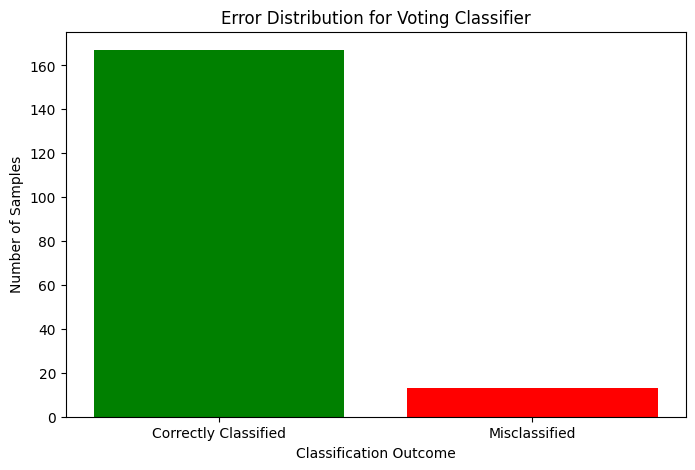

In [325]:
plt.figure(figsize=(8, 5))
plt.bar(['Correctly Classified', 'Misclassified'], error_distribution, color=['green', 'red'])
plt.title("Error Distribution for Voting Classifier")
plt.xlabel("Classification Outcome")
plt.ylabel("Number of Samples")
plt.show()

# Stacking Clasifier: on 500 emails

In [326]:
from sklearn.ensemble import StackingClassifier

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('Random Forest', rf_model),
        ('Logistic Regression', lr_model),
        ('SVM', svm_model),
        ('XGBoost', xgb_model)
    ],
    final_estimator=LogisticRegression(),
    stack_method='predict_proba',
    n_jobs=-1
)

In [327]:
print("Size of Training Data (TF-IDF):", X_train_tfidf.shape)
print("Size of Testing Data (TF-IDF):", X_test_tfidf.shape)

Size of Training Data (TF-IDF): (350, 5000)
Size of Testing Data (TF-IDF): (150, 5000)


In [328]:
stacking_clf.fit(X_train_tfidf, y_train)
y_pred_stacking = stacking_clf.predict(X_test_tfidf)
y_pred_proba_stacking = stacking_clf.predict_proba(X_test_tfidf)[:, 1]

In [329]:
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
auc_stacking = roc_auc_score(y_test, y_pred_proba_stacking)
logloss_stacking = log_loss(y_test, y_pred_proba_stacking)
mcc_stacking = matthews_corrcoef(y_test, y_pred_stacking)

report_stacking = classification_report(y_test, y_pred_stacking)

print("Metrics for Stacking Classifier:")
print(f"Accuracy: {accuracy_stacking:.4f}")
print(f"AUC: {auc_stacking:.4f}")
print(f"Log Loss: {logloss_stacking:.4f}")
print(f"MCC: {mcc_stacking:.4f}\n")
print("Classification Report:")
print(report_stacking)

Metrics for Stacking Classifier:
Accuracy: 0.9600
AUC: 0.9858
Log Loss: 0.1571
MCC: 0.9200

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        75
           1       0.96      0.96      0.96        75

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



# Stacking Classifier: on 600 emails

add 100 emails

In [330]:
# prev 500
print("Original Training Size:", X_train.shape)
print("Original Test Size:", X_test.shape)
print("Additional Data Size:", X_additional.shape)

Original Training Size: (350,)
Original Test Size: (150,)
Additional Data Size: (100,)


In [331]:
# 600
X_combined = pd.concat([X_train, X_test, X_additional], ignore_index=True)
y_combined = pd.concat([y_train, y_test, y_additional], ignore_index=True)
print("Combined Data Size (Raw):", X_combined.shape)
print("Combined Label Size:", y_combined.shape)

Combined Data Size (Raw): (600,)
Combined Label Size: (600,)


In [332]:
X_combined_tfidf = tfidf.fit_transform(X_combined)
print("Total Data Size (TF-IDF):", X_combined_tfidf.shape)
print("Total Label Size:", y_combined.shape)

Total Data Size (TF-IDF): (600, 5000)
Total Label Size: (600,)


In [333]:
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(
    X_combined_tfidf, y_combined, test_size=0.3, random_state=42, stratify=y_combined
)
print("New Training Size:", X_train_total.shape)
print("New Test Size:", X_test_total.shape)

New Training Size: (420, 5000)
New Test Size: (180, 5000)


In [334]:
stacking_clf.fit(X_train_total, y_train_total)
y_pred_stacking_total = stacking_clf.predict(X_test_total)
y_pred_proba_stacking_total = stacking_clf.predict_proba(X_test_total)[:, 1]

accuracy_stacking_total = accuracy_score(y_test_total, y_pred_stacking_total)
auc_stacking_total = roc_auc_score(y_test_total, y_pred_proba_stacking_total)
logloss_stacking_total = log_loss(y_test_total, y_pred_proba_stacking_total)
mcc_stacking_total = matthews_corrcoef(y_test_total, y_pred_stacking_total)
report_stacking_total = classification_report(y_test_total, y_pred_stacking_total)


print("Metrics for Stacking Classifier on Combined Data:")
print(f"Accuracy: {accuracy_stacking_total:.4f}")
print(f"AUC: {auc_stacking_total:.4f}")
print(f"Log Loss: {logloss_stacking_total:.4f}")
print(f"MCC: {mcc_stacking_total:.4f}\n")
print("Classification Report:")
print(report_stacking_total)

Metrics for Stacking Classifier on Combined Data:
Accuracy: 0.9444
AUC: 0.9884
Log Loss: 0.1509
MCC: 0.8889

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        89
           1       0.95      0.95      0.95        91

    accuracy                           0.94       180
   macro avg       0.94      0.94      0.94       180
weighted avg       0.94      0.94      0.94       180



Dsitribusi error

In [335]:
errors_stacking = y_pred_stacking_total != y_test_total
error_magnitude_stacking = np.abs(y_test_total - y_pred_proba_stacking_total)
error_values_stacking = error_magnitude_stacking[errors_stacking]
error_values_sorted_stacking = np.sort(error_values_stacking)

In [336]:
error_distribution_stacking = np.bincount(errors_stacking.astype(int))
print("Error Distribution for Stacking Classifier:")
print(f"Correctly Classified: {error_distribution_stacking[0]}")
print(f"Misclassified: {error_distribution_stacking[1]}")

Error Distribution for Stacking Classifier:
Correctly Classified: 170
Misclassified: 10


# 700 Data: Add 100 more

In [337]:
X_new_100 = X_additional.copy()  
y_new_100 = y_additional.copy()

In [338]:
X_combined_700 = pd.concat([X_combined, X_new_100], ignore_index=True)
y_combined_700 = pd.concat([y_combined, y_new_100], ignore_index=True)

In [339]:
print("700 Combined Data Size (Raw):", X_combined_700.shape)
print("700 Combined Label Size:", y_combined_700.shape)

700 Combined Data Size (Raw): (700,)
700 Combined Label Size: (700,)


In [340]:
X_combined_700_tfidf = tfidf.fit_transform(X_combined_700)
print("700 Combined Data Size (TF-IDF):", X_combined_700_tfidf.shape)
print("700 Combined Label Size:", y_combined_700.shape)

700 Combined Data Size (TF-IDF): (700, 5000)
700 Combined Label Size: (700,)


In [341]:
X_train_700, X_test_700, y_train_700, y_test_700 = train_test_split(
    X_combined_700_tfidf, y_combined_700, test_size=0.3, random_state=42, stratify=y_combined_700
)
print("New Training Size (700):", X_train_700.shape)
print("New Test Size (700):", X_test_700.shape)

New Training Size (700): (490, 5000)
New Test Size (700): (210, 5000)


## Voting Classifier: 700 emails

In [342]:
voting_clf.fit(X_train_700, y_train_700)
y_pred_voting_700 = voting_clf.predict(X_test_700)
y_pred_proba_voting_700 = voting_clf.predict_proba(X_test_700)[:, 1]

In [343]:
accuracy_voting_700 = accuracy_score(y_test_700, y_pred_voting_700)
auc_voting_700 = roc_auc_score(y_test_700, y_pred_proba_voting_700)
logloss_voting_700 = log_loss(y_test_700, y_pred_proba_voting_700)
mcc_voting_700 = matthews_corrcoef(y_test_700, y_pred_voting_700)
report_voting_700 = classification_report(y_test_700, y_pred_voting_700)

In [344]:
print("Metrics for Voting Classifier on 700 Samples:")
print(f"Accuracy: {accuracy_voting_700:.4f}")
print(f"AUC: {auc_voting_700:.4f}")
print(f"Log Loss: {logloss_voting_700:.4f}")
print(f"MCC: {mcc_voting_700:.4f}\n")
print("Classification Report:")
print(report_voting_700)

Metrics for Voting Classifier on 700 Samples:
Accuracy: 0.9571
AUC: 0.9942
Log Loss: 0.1928
MCC: 0.9146

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       104
           1       0.94      0.97      0.96       106

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



## Stacking Classifier: on 700 emails

In [345]:
stacking_clf.fit(X_train_700, y_train_700)
y_pred_stacking_700 = stacking_clf.predict(X_test_700)
y_pred_proba_stacking_700 = stacking_clf.predict_proba(X_test_700)[:, 1]

In [346]:
accuracy_stacking_700 = accuracy_score(y_test_700, y_pred_stacking_700)
auc_stacking_700 = roc_auc_score(y_test_700, y_pred_proba_stacking_700)
logloss_stacking_700 = log_loss(y_test_700, y_pred_proba_stacking_700)
mcc_stacking_700 = matthews_corrcoef(y_test_700, y_pred_stacking_700)
report_stacking_700 = classification_report(y_test_700, y_pred_stacking_700)

In [347]:
print("Metrics for Stacking Classifier on 700 Samples:")
print(f"Accuracy: {accuracy_stacking_700:.4f}")
print(f"AUC: {auc_stacking_700:.4f}")
print(f"Log Loss: {logloss_stacking_700:.4f}")
print(f"MCC: {mcc_stacking_700:.4f}\n")
print("Classification Report:")
print(report_stacking_700)

Metrics for Stacking Classifier on 700 Samples:
Accuracy: 0.9571
AUC: 0.9971
Log Loss: 0.0913
MCC: 0.9146

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       104
           1       0.94      0.97      0.96       106

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



### Comparison of Ensemble models

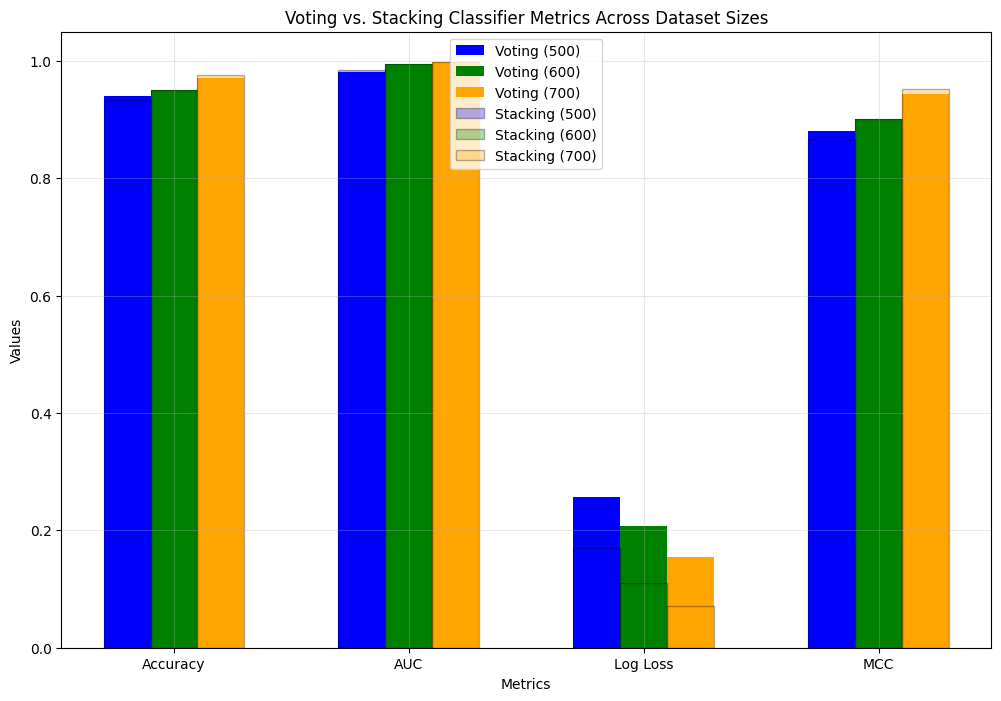

In [348]:
# Voting v.s. Stacking Classifier Bar Chart
metrics = ["Accuracy", "AUC", "Log Loss", "MCC"]
voting_metrics_500 = [0.94, 0.9820, 0.2573, 0.8801]
voting_metrics_600 = [0.95, 0.9956, 0.2072, 0.9014]
voting_metrics_700 = [0.9714, 0.9986, 0.1546, 0.9435]

stacking_metrics_500 = [0.9333, 0.9847, 0.1693, 0.8667]
stacking_metrics_600 = [0.95, 0.9951, 0.1097, 0.9005]
stacking_metrics_700 = [0.9762, 0.9985, 0.0709, 0.9528]


x = np.arange(len(metrics))  
width = 0.2  

plt.figure(figsize=(12, 8))
plt.bar(x - width, voting_metrics_500, width, label="Voting (500)", color='blue')
plt.bar(x, voting_metrics_600, width, label="Voting (600)", color='green')
plt.bar(x + width, voting_metrics_700, width, label="Voting (700)", color='orange')

plt.bar(x - width, stacking_metrics_500, width, label="Stacking (500)", alpha=0.3, color='blue', edgecolor='black')
plt.bar(x, stacking_metrics_600, width, label="Stacking (600)", alpha=0.3, color='green', edgecolor='black')
plt.bar(x + width, stacking_metrics_700, width, label="Stacking (700)", alpha=0.3, color='orange', edgecolor='black')

# Chart details
plt.title("Voting vs. Stacking Classifier Metrics Across Dataset Sizes")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)  
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Comparison of All Models

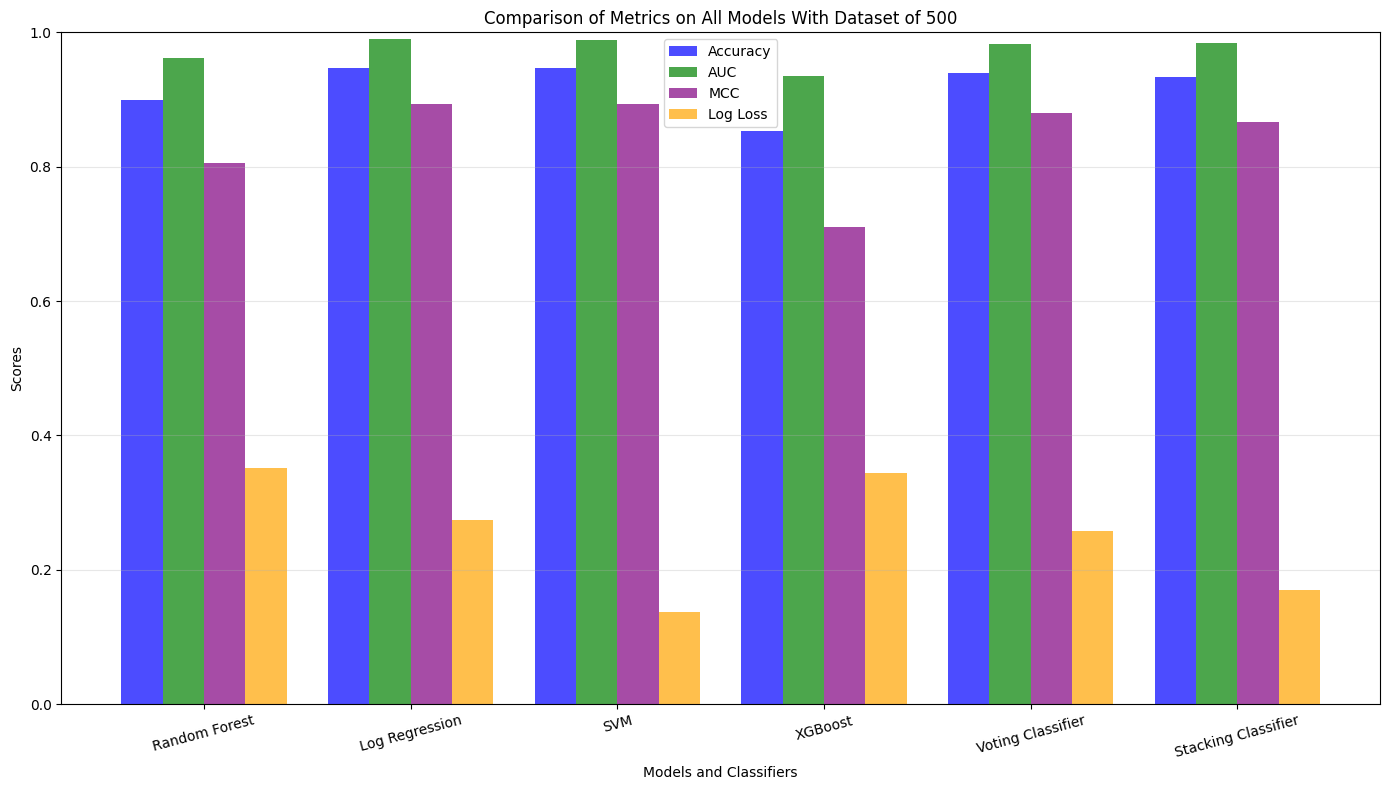

In [349]:
# compare all models on 500 (accuracy and auc)

labels = ["Random Forest", "Log Regression", "SVM", "XGBoost", "Voting Classifier", "Stacking Classifier"]

accuracy = [0.90, 0.946667, 0.946667, 0.853333, 0.94, 0.9333]
auc = [0.9624, 0.989511, 0.989156, 0.934756, 0.982, 0.9847]
mcc = [0.805823, 0.893651, 0.893651, 0.710721, 0.8801, 0.8667]
log_loss = [0.350897, 0.273688, 0.136842, 0.344038, 0.2573, 0.1693]

plt.figure(figsize=(14, 8))
x = np.arange(len(labels))
width = 0.2

plt.bar(x - 1.5 * width, accuracy, width, label="Accuracy", color="blue", alpha=0.7)
plt.bar(x - 0.5 * width, auc, width, label="AUC", color="green", alpha=0.7)
plt.bar(x + 0.5 * width, mcc, width, label="MCC", color="purple", alpha=0.7)
plt.bar(x + 1.5 * width, log_loss, width, label="Log Loss", color="orange", alpha=0.7)

plt.title("Comparison of Metrics on All Models With Dataset of 500")
plt.xlabel("Models and Classifiers")
plt.ylabel("Scores")
plt.xticks(x, labels, rotation=15)
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3, axis="y")
plt.tight_layout()
plt.show()